## Overview

This notebook provides an exploration of audio data from animals, performing analysis through statistical analysis and visualisation of audio samples

Author: Andrew Kudilczak

## Pre-requisites to run this notebook.

This notebook explores a data set that is stored on the Deakin teams channel here:

[DataSets Folder](https://deakin365.sharepoint.com/:f:/r/sites/DataBytes2/Shared%20Documents/Project%20Echo/DataSets?csf=1&web=1&e=oxQZWj)

This dataset was not uploaded to git to keep the repository light weight.  This notebook assumes the dataset has been mapped to your local drive - see paths below

## Development environment

This notebook requires a conda environment setup in accordance with [Data Science Environment Setup](https://github.com/stephankokkas/Project-Echo/tree/main/src)

In [89]:
# disable warnings to tidy up output
import warnings
warnings.filterwarnings("ignore")

# some basic libraries 
from platform import python_version
import pandas as pd
import seaborn as sns
import numpy as np
import os
import random

# plot support
import plotly.express as px
import matplotlib.pyplot as plt

# tensorflow support
import tensorflow as tf
import tensorflow_datasets as tfds

# reading audio datasets
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

# turn off tensorflow warnings
tf.get_logger().setLevel('ERROR')

# turn off absl warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# print system information
print('Librosa Version    : ', python_version())
print('TensorFlow Version : ', tf.__version__)
print('Librosa Version    : ', librosa.__version__)

Librosa Version    :  3.9.13
TensorFlow Version :  2.10.0
Librosa Version    :  0.9.2


In [90]:
# below code adapted from:
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [91]:
# set system parameters
DATASET_PATH = 'C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/'
SAMPLE_RATE  = 32000

In [92]:
def dataset_from_dir_structure(dataset_path):
    # each subdir represents a data class
    subfolders = [f for f in os.scandir(dataset_path) if f.is_dir()]

    dataset_filenames = []
    dataset_labels = []
    for subfolder in subfolders:
        # now get all the files in the folder
        audiofiles = [f for f in os.scandir(subfolder.path) if f.is_file()]
        
        for audiofile in audiofiles:
            dataset_filenames.append(audiofile.path)
            dataset_labels.append(subfolder.name)
            
    # create the dataset from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((dataset_filenames, dataset_labels))
    
    return dataset

In [93]:
# create the dataset
file_dataset = dataset_from_dir_structure(DATASET_PATH)
print("Dataset Samples: ", len(file_dataset))

# print three elements of the file_dataset pipeline
for file, label in file_dataset.take(3):
    print ("FILE: ",file.numpy().decode("utf-8"), " LABEL: ", label.numpy().decode("utf-8"))

Dataset Samples:  524
FILE:  C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/brant\XC112697.ogg  LABEL:  brant
FILE:  C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/brant\XC127691.ogg  LABEL:  brant
FILE:  C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/brant\XC143518.ogg  LABEL:  brant


In [94]:
import tensorflow_io as tfio

# this function converts filename to actual audio 2d array data
def load_audio_file(audio_file, label):
    audio = tfio.audio.AudioIOTensor(audio_file, dtype=tf.float32)
    
    # convert to tensor and keep only the left channel
    audio_t = audio.to_tensor()[:,0]
    
    return audio_t,label

# now to create a pipeline to load the audio file
audio_dataset = (file_dataset
                 .map(load_audio_file)
                 .cache()
                 .repeat()
                 )

# check the data loaded ok
for audio, label in audio_dataset.take(3):
    audio_np = audio.numpy()
    print (audio_np.shape, np.max(audio_np), np.min(audio_np), label.numpy().decode("utf-8"))

(2990916,) 0.46234378 -0.55403256 brant
(1239552,) 1.0097641 -0.92063993 brant
(1601620,) 1.000324 -0.80471176 brant


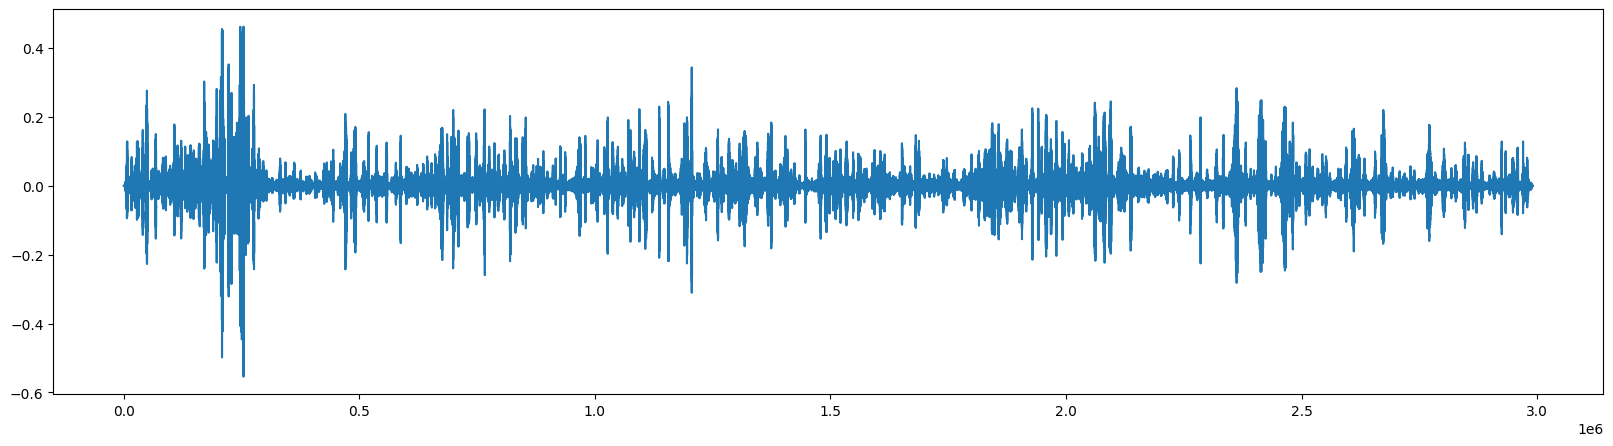

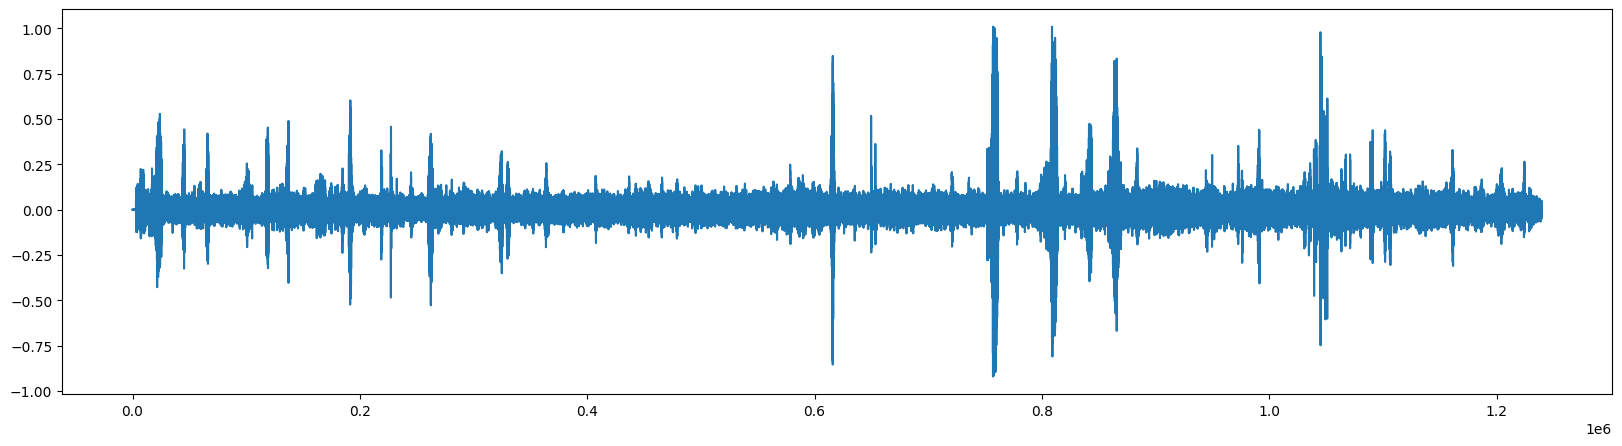

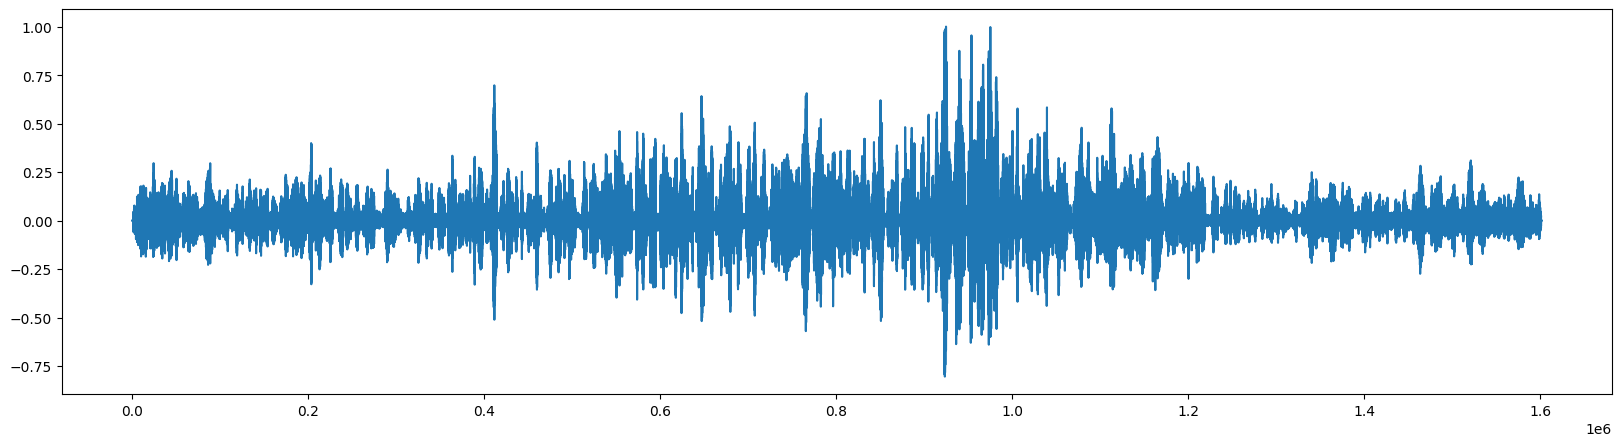

In [95]:
# plot three samples of audio
for audio, label in audio_dataset.take(3):
    audio_np = audio.numpy()
    plt.figure(figsize=(20,5))
    plt.plot(audio_np)